# Project: **Finding Lane Lines on the Road** 
***

<div class="alert alert-block alert-warning" style="text-align: justify">Goal is to piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).
After, try it out on the video stream. or <br />
**Tools:** color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection. or <br />
(** Later, explore and try other techniques that were not presented in the lesson**)
</div>

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> output should look like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [335]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Reading in Images.---(Just to illustrate basic stats)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


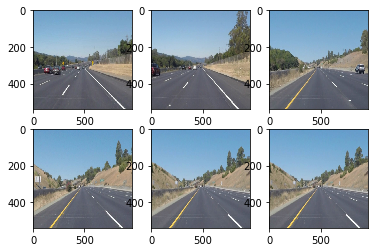

In [336]:
import os
#reading in images
test_images_input = os.listdir("test_images/")
images=[]
for image in  os.listdir("test_images/"):
    images.append(mpimg.imread(os.path.join("test_images/",image)))
    
for image in images:
    print('This image is:', type(image), 'with dimensions:', image.shape)
# plot with various axes scales
plt.figure(1)
plt.subplot(231)
plt.imshow(images[0],aspect='auto')

plt.subplot(232)
plt.imshow(images[1],aspect='auto')

plt.subplot(233)
plt.imshow(images[2],aspect='auto')

plt.subplot(234)
plt.imshow(images[3],aspect='auto')

plt.subplot(235)
plt.imshow(images[5],aspect='auto')

plt.subplot(236)
plt.imshow(images[5],aspect='auto')

## Helper Functions:----( definition & explaination for each function)

In [415]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel but
    NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black."""
    #defining a blank mask to start with
    mask = np.zeros_like(img)                        
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2: 
        channel_count = img.shape[2]                 
        ignore_mask_color = (255,) * channel_count   # 3 channel color mask
    else:
        ignore_mask_color = 255                      # 1 channel color mask
    # Fill the polygon defined by "vertices".  
    cv2.fillPoly(mask, vertices, ignore_mask_color)  # fill with RED color
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """`img` should be the output of a Canny transform.    
    Returns an image with hough lines drawn."""
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # by using the dimensions of original image, creating a complete Blacked out copy of it.
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) 
    # calling the draw_lines function, which will draws lines on
    # the hough returned coordinates in fully Blacked-out Image.
    draw_lines(line_img, lines)                                             
    # this image has connected(line drawn) coordinates in complete Black-out image. 
    return line_img
    
def draw_lines(img, lines, color=[255,0,0], thickness=2):
    verticle_lines=[]   #  m=infinity
    horizontal_lines=[] #  m=0
    left_lines=[]   #  m=+ve
    right_lines=[]   #  m=-ve
    postiveSlope=0     #  +veSlopeSUM
    negtiveSlope=0     #  -veSlopeSUM
#     Seperate Left lines & Right Lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (y2-y1)/(x2-x1) < 0.2 and (y2-y1)/(x2-x1) > -0.8:
                left_lines.append(line)
                postiveSlope+= ((y2-y1)/(x2-x1)) 
            elif (y2-y1)/(x2-x1) > 0.2 and (y2-y1)/(x2-x1) < 0.8:
                right_lines.append(line)
                negtiveSlope+= abs((y2-y1)/(x2-x1))                
                
#    coordinates average left_lanes , right_lanes
    LL_avg= np.average(left_lines, axis=0)
#     print('LL_avg',LL_avg)
    RL_avg= np.average(right_lines, axis=0)
#     print('RL_avg',RL_avg)
#    calculate the slope_avg & Intercept_avg for left_lanes , right_lanes

    for x1_avg,y1_avg,x2_avg,y2_avg in line:
        x1=x1_avg
        y1=y1_avg
        x2=x2_avg
        y2=y2_avg
        LL_slope_avg     = (y2 - y1)/(x2 - x1)+1
        LL_Intercept_avg = y1 - (LL_slope_avg * x1)
#     for x1_avg,y1_avg,x2_avg,y2_avg in RL_avg:
        x1=x1_avg
        y1=y1_avg
        x2=x2_avg
        y2=y2_avg
        RL_slope_avg     = (y2 - y1)/(x2 - x1)-1
        RL_Intercept_avg = y1 - (RL_slope_avg * x1)
        
#    Calc the Lowest coordinate for left_lanes & right_lanes using x = (y - b)/m
    min_left_y  =  539#find_minimum_y(left_lines)
    min_left_x  =  867#calculate_x(min_left_y, LL_Intercept_avg, LL_slope_avg) #affecting right line
    
    min_right_y =  539#find_minimum_y(right_lines)
    min_right_x =  165#calculate_x(min_right_y, RL_Intercept_avg, RL_slope_avg) # affecting left line..?

#    Calc the highest coordinate for left_lanes & right_lanes using x = (y - b)/m
    max_left_y  =  320#find_maximum_y(left_lines)
    max_left_x  =  502#calculate_x(max_left_y,LL_Intercept_avg, LL_slope_avg) # affecting right line..?

    max_right_y =  320#find_maximum_y(right_lines)    
    max_right_x =  465#calculate_x(max_right_y,RL_Intercept_avg, RL_slope_avg)

    """This function draws `lines` with `color` and `thickness`."""

#   left_lane_lines drawn:  ==================                                         
    cv2.line(img, (min_left_x, min_left_y), (max_left_x, max_left_y), [255,255,0], thickness=3)
#   right_lane_lines drawn  ==================  
    cv2.line(img, (min_right_x, min_right_y), (max_right_x, max_right_y), [0,0,255], thickness=3)

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α, β, λ):
    """`img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    `initial_img` should be the image before any processing.
    The result image is computed as follows:
                    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!"""
    return cv2.addWeighted(img, α, initial_img, β, λ)

## Added Helper functions to support draw_lines() .--Now they are not working, as I fixed x & y manually for annotation purpose

In [416]:
# '''Question: I still did not get clarity on Why I have to calculate x when I can retrive exact x_min for y_min as well as maxs.?????????
# slope intercept form(x = (y - b)/m)'''    
# def calculate_x(y,intercept, slope):
#     x= ((y-intercept)//slope)
#     return int(x)

# '''This function simply calculates the min of all y's (y1 & y2) and catches their corresponding x's., But due to the issue mentioned above
# I calculted x's for y's with the help of calc_x() function.'''
# def find_minimum_y(lane_lines):
#     for line in lane_lines:
#         temp=960
#         temp1=960
#         for x1,y1,x2,y2 in line:
#             if temp>=y1:
#                 temp=y1
#                 if temp==y1:
#                     temp_x1=x1
#             if temp1>=y2:
#                 temp1=y2
#                 if temp1==y2:
#                     temp1_x2=x2
#     if temp<temp1:
#         min_y=temp
#         min_x=temp_x1
#     else:
#         min_y=temp1
#         min_x=temp1_x2
#     return int(min_y)

# '''function calculate maximum y'''
# def find_maximum_y(lane_lines):
#     for line in lane_lines:
#         temp=0
#         temp1=0
#         for x1,y1,x2,y2 in line:
#             if temp<=y1:
#                 temp=y1
#                 if temp==y1:
#                     temp_x1=x1
#             if temp1<=y2:
#                 temp1=y2
#                 if temp1==y2:
#                     temp1_x2=x2
#     if temp>temp1:
#         max_y=temp
#         max_x=temp_x1
#     else:
#         max_y=temp1
#         max_x=temp1_x2    
#     return int(max_y) 

### Building a Lane Finding Pipeline--- using Helper functions.

In [417]:
'''This function pipeline that takes in an input image and outputs annotated Lane-lines'''
def laneFindingPipeLine(img):
    '''Inorder to apply canny algorithm, We have to convert color image to gray 
    i.e a single channel image. Gray image helps us to clearly identify, 
    1. DARK/ BRIGHT/ GRAY(in between) pixels in the image. 
    2. Rapid changes in the brightess which are edges/dots detected by Canny Algo.'''
    gray_image = grayscale(img)

    '''filter-out noise and spurious gradients by averaging  with gaussian filter,
    keeping Kernel_size = 5, **always select a odd size number.'''
    kernel_size=5
    blur_gray = gaussian_blur(gray_image, kernel_size)

    '''now, we can apply canny algorithm, that apply its gaussian filter--> 
    finds the gradient strength & direction(you get thick edges)-->
    apply non-max. suppression(get thin/candidate edges)-->
    Hysteresis with the help of thresholds specifies in the arguments'''
    low_threshold  = 70
    high_threshold = 140
    canny_edges = canny(blur_gray, low_threshold, high_threshold)

    '''Now, you have a edge-detected image(SINGLE CHANNEL) : which has edges all over the image 
    based on you detection criterion(Arguments of canny_algorithm). This doesn't
    solve our purpose. As canny_edges are all over the image.
    We need to narrow-down our area of visibility to not to let our algorithm confuse.
    By creating a REGION OF INTEREST (a POLYGON around the lane lines).
    This function 
    1. takes the coordinates of the polygon and draws a polygon in the image,
    2. then fill it with a RED color <-- this becomes your mask (a specific area to look on.)
    3. then it performs bitwise AND with canny_edge_detected_image(which is full of edges everywhere) 
       AND mask_image(just a plane RED POLYGON SHAPE in the image(SINGLE COLOR-GRAY))
       --> gives a canny_edge_detected_masked_image(SINGLE COLOR-GRAY)
    So, now you have clear RED-HIGHLIGHTNED canny- edges....BEAUTIFULL..!!! :)
    Note: Creating a mask is independent of any operation'''
    vertices = np.array([[(0,539),(425, 340), (510, 320), (959,539)]], dtype=np.int32)
    masked_image = region_of_interest(blur_gray, vertices)

    '''Moreover, you want to create Mask on the canny_edges that's why you have 
    to do a bit-wise AND to get only the masked-canny_edges Image.
            "Issue": masked_image shape (540, 960, 3) and canny_edges shape (540, 960),
            above I have given blur_gray instead of img to make them of same shape.
    Ultimately, we need a SINGLE COLOR IMAGE(GRAY) as an input to hough_lines()
    that take these edges/pixels check their intersections in Hought space and 
    connect them in Image space'''
    masked_canny_edges = cv2.bitwise_and(masked_image, canny_edges)

    '''Work is not done YET..!! We just have dotted-lane-lines detected.
    So, we connect them..? How we know which dot to connect with which other dot,
    & how many dots to connect? ...TRICKY SITUATION...!!!
    Awesome Manipulation by hough, We have dots in our image space, 
    which equivalent to a line for each dot in Hough space. 
    And, collinear points in image space is equivalent to respective lines 
    passing through common intersection point/pixel in Hough space. 
    Also, in Hough space we have grids cells, which helps to catch all the edges/dots
    in images space which are not collinear but very much near to collinear points 
    by adjusting THRESHOLD parameter in below function. The more count we get of lines 
    passing through a grid pixel in hough space, the more we get 
    collinear/near-collinear edges/dots in out image space.
    This way we will be able to clear identify the sequence of coordinates of all 
    near-collinear points in the canny_edge_detected_masked_image ......AMAZING..!!
    
    Now, you have the coordinates, Connect them with a line, by calling custom draw_lines()'''
    rho = 1
    theta = np.pi/180
    threshold = 12
    min_line_len = 10
    max_line_gap = 2
    # --> will call draw lines & you get a Blacked-out image with connected Hough returned coordinates.
    line_img = hough_lines(masked_canny_edges, rho, theta, threshold, min_line_len, max_line_gap)

    '''Now we have
                1. a image with hough Annotated lines.
                2. a original image. 
    this function will give weights to each pixel & glue them together. 
    Remember, before gluing, the dimension should be same, else it pops out errors.'''
    output = weighted_img(line_img, img, α=0.5, β=1.0, λ=0.)
    return output

## Reading Test Images

In [418]:
import os,re
INPUT_PATH  = 'test_images/'
OUTPUT_PATH = 'test_images_output/'
# Automate the data fetching process.
def read_save_images(input_dir=INPUT_PATH, output_dir=OUTPUT_PATH):           
    #     read input images into a list
    test_images_input = os.listdir(input_dir)                                 
    #     output directory doesn't exist then create one
    if not os.path.isdir(output_dir):                                         
        os.makedirs(output_dir)
    
    for text_images in test_images_input:
        # read each image into program
        image = mpimg.imread( os.path.join(input_dir,text_images))   
        # send this image to your pipeline to process it
        pipeLine_output_image = laneFindingPipeLine(image)                    
        modify_name = re.sub(r'\.jpg$', '', text_images)
        # put the final image into the directory
        mpimg.imsave( os.path.join(output_dir,modify_name+'_output.jpg'),pipeLine_output_image) 
    return  

### Calling the pipeline

In [419]:
# simply calling the pipeline here
read_save_images()

# <div class="alert alert-block alert-danger">&#9986;&#9986;Application of my Pipeline on Images is tested and completed  here&#9986;&#9986;</div>

## Test on Videos now

In [360]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

''' Function that calls my pipeline on each frame of my video, Actually,a video is a sequence of images. :)'''
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)  
    result = laneFindingPipeLine(image)   
    return result                    

### Reading Videos and generating a Output:----------Trying to fix below code--to automate the video fetching process.

In [404]:
# import os,re
# INPUT_PATH  = 'test_videos/'
# OUTPUT_PATH = 'test_videos_output/'
# # Automate the data fetching process.
# def read_save_videos(input_dir=INPUT_PATH, output_dir=OUTPUT_PATH):           
#     #     read input videos into a list
#     test_video_input = os.listdir(input_dir)                                 
#     #     output directory doesn't exist then create one
#     if not os.path.isdir(output_dir):                                         
#         os.makedirs(output_dir)
#     print(test_video_input)    
#     for test_video in test_video_input:
#         # read each video into program
#         clip1 = VideoFileClip("test_videos/"+test_video )
#         #NOTE: this function expects color images!!
#         white_clip = clip1.fl_image(process_image) # calling to my pipeline
#         modify_name = re.sub(r'\.mp4$', '', test_video)
#         # put the final video into the directory
#         output=output_dir+modify_name+'_output.mp4'
#         print(output)
#         %time white_clip.write_videofile(output, audio=True)

# ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# ## To do so add .subclip(start_second,end_second) to the end of the line below
# ## Where start_second and end_second are integer values representing the start and end of the subclip
# ## You may also uncomment the following line for a subclip of the first 5 seconds
# ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

# read_save_videos()

In [406]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



 78%|███████▊  | 174/222 [00:02<00:00, 72.98it/s]WARNING:py.warnings:/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)

  ret = ret.dtype.type(ret / rcount)


100%|█████████▉| 221/222 [00:02<00:00, 83.30it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1.96 s, sys: 370 ms, total: 2.33 s
Wall time: 3.06 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [407]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [408]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



100%|█████████▉| 681/682 [00:08<00:00, 84.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 6.1 s, sys: 898 ms, total: 7 s
Wall time: 8.47 s


In [409]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [420]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



 18%|█▊        | 46/251 [00:00<00:02, 71.27it/s]WARNING:py.warnings:/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in int_scalars



 28%|██▊       | 70/251 [00:01<00:03, 45.56it/s]WARNING:py.warnings:/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)

  ret = ret.dtype.type(ret / rcount)


 38%|███▊      | 95/251 [00:01<00:03, 40.97it/s]WARNING:py.warnings:/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in int_scalars



100%|██████████| 251/251 [00:06<00:00, 40.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 4.64 s, sys: 688 ms, total: 5.33 s
Wall time: 7.06 s


In [421]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### <div class="alert alert-block alert-danger">&#9986;&#9986;Application of my Pipeline on Videos is tested working on optional Challenge.     ** I have question to reviewer, Can I changes the fixed x's & y's for the challenge video, As I can see in the video generated in the folder.The annotation is misplaced. So My question is, Are you looking for soem universal x's / y's that once fixed can be generalised to any image to annotate Lane lines or we have to adjust for every image**&#9986;&#9986;</div>